# Kyle Thornton
# Creating AI enabled Systems
# System Project

## Overview
The purpose of this project was to analyze what the best architecture to make a chess categorization AI was and what would be the accuracy vs. the number of categories. This includes MLPs and CNNs along with other architecture that was tested to see if it would be the best at a standard number of categories before choosing one and increasing. This led me to choose my model and start from three categories (one for black winning, one for white winning , and one for neutral) all the way upto 11 different categories. After, I plotted the accuracy vs. the categories.

## Decomposition

Chess has been played for nearly 1500 years, but new chess neural networks can lead to brand new insights that have not be theorized by humans. This can be seen in the way we evaluate positions, opening theory, and new moves. Chess artificial intelligences, specifically neural network based ones, have popularized new openings and have shown their prowess by beating classical brute force programs. Another reason to build specifically a neural network program is that it doesn’t suffer from the same limited foresight that classical programs do, like the older version of Stockfish.

I have always been passionate about chess and have played the game for over 13 years. I concluded I wanted to make my own program while reading parts of the books _The AI Revolution in Chess_ by Joshua Doknjas. Here are two articles written by him that go over these ideas in detail (with example positions). [How the AI revolution Impacted Chess Part 1](https://en.chessbase.com/post/how-the-ai-revolution-impacted-chess-1-2) and [How the AI revolution Impacted Chess Part 2](https://en.chessbase.com/post/how-the-ai-revolution-impacted-chess-2-2) 


Now the what if question is less interesting as this has already been done before. The question could be what if the chess engine was a mixture between the two ways of creating an engine, like the newer Stockfish is. However, I find the neural network approach too interesting and original.

The purpose of this system is to approach a regression problem with the increasing number of categories and test accuracy as we increase. This allows for us to see how well our model would do on a regression problem while also being able to plot accuracy against number of categories for a visual representation. 

## Domain Expertise
The set of stakeholders that would interact with this system are:	
- People who play chess and want to improve their game by learning about different positions.
	
- People who create chess AI/evaluation systems and want to improve or change their system.

The purpose of this software is to create a chess engine later using it for evaluation of the board state in order to choose a move in the future. This requires that the system not only be **accurate** but also that it be **fast**.

Out of the two stakeholders the ones most impacted by this software are the people who want to create chess AI/evaluation systems. This is because there are better ways to teach yourself the game of chess rather than sitting and looking at the output of a neural network, such as playing, reading, and observing. So most of the decisions I have made on model creation and preprocessing have been about making the model as fast as possible to take in FEN strings from the chess library and return a one hot encoded array.

In [3]:
import chess
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sn

## Data 
This was one of the most challenging parts of the project as getting the correct amount of data, preprocessing it correctly, and good distribution of data each posed its own challenge. The data itself is composed of two columns: a FEN string to represent the board and an evaluation outputted by Stockfish. Getting the correct amount and type of data was important because if you only used data from chessData.csv you would get mostly even positions not allowing the network to learn. This can be seen remedied by the histogram below. The random_evals.csv and tactic_evals.csv are used to remedy this aswell as test the networks capabilities of pattern recognition. The data was gathered by taking in chess positions in games and feeding them into stockfish to get an evaluation. The cell aboive contains some of the required libraries for this project and the rest can be found throughout this notebook.

The hardest part of this project was preprocessing the data and I have attached a file to this project that contains all the iterations my preprocessing went through. The first thing I had to do was change the evaluation data from a string to an integer. I was able to do this using simple .loc commands and evaluating all the checkmate in "x" moves to be +- 1500 centipawns ahead. This allowed me to have spikes at +-1500 and to use the to_numeric function to change the data type. The hard part was one hot encoding the FEN string in a way that allowed the network to learn with speed and accuracy. My first attempt was a simple one hot encoding, which I was able to speed up using array indexing, of each peice representing each piece as a 1 in a 1 by 12 array. The network was unable to learn using this method and I had to change to making the black or white pieces a negative one depending on whose move it was. This was closer but still not quite where I wanted it to be. Lastly, I used the same one hot encoding but if it was blacks move I would flip and reverse the case of the FEN string and multiply the evaluation by -1 (or take the total number of categories - 1 subtracted by the true value. This allowed for the model to not only learn but to learn quickly aswell as allowed me to use the Adam optimizer but this will be discussed in model selection.

I chose to make the cutoff for the evaluations to be the same 1,500 centipawn evaluation I made checkmates as I found that in the chessData.csv file there were odd outliers that would throw off the regression model by quite a bit, but not effect the categorical model. Since regression is the long term goal I made this cutoff.

In [2]:
df1 = pd.read_csv("chessData.csv").head(150000)
df2 = pd.read_csv("random_evals.csv").head(150000)
df3 = pd.read_csv("tactic_evals.csv").head(150000)
df3 = df3.drop(['Move'],axis = 1)
df = pd.concat([df1,df2,df3], ignore_index = True)
df.head()

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26


In [3]:
df.loc[(df["Evaluation"].str[0]== "#")&(df["Evaluation"].str[1]=="+"), ["Evaluation"]] = "1500"
df.loc[(df["Evaluation"].str[0]=="#")&(df["Evaluation"].str[1]=="-"), ["Evaluation"]] = "-1500"
df.loc[df["Evaluation"].str[0]== "+", ["Evaluation"]] = df["Evaluation"].str[1:]
df.loc[df.Evaluation.str[1] == "+", ["Evaluation"]] = "23"
df['Evaluation'] = pd.to_numeric(df["Evaluation"])

(array([ 23726.,   9912.,  29254.,  47068.,  77633., 131873.,  50599.,
         32521.,  10370.,  25620.]),
 array([-1500., -1200.,  -900.,  -600.,  -300.,     0.,   300.,   600.,
          900.,  1200.,  1500.]),
 <BarContainer object of 10 artists>)

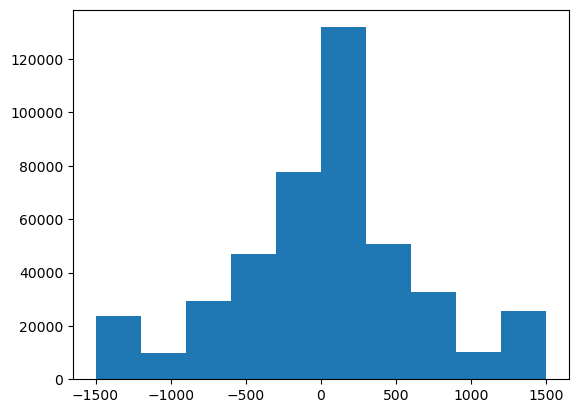

In [4]:
df = df[(df.Evaluation <= 1500) & (df.Evaluation >= -1500)]
plt.hist(df.Evaluation)

In [5]:
piece_map = ["P", "N", "B", "R", "Q", "K"]
piece_map = {i: piece_map.index(i) for i in piece_map}

def parse_row(row):
    ret = []
    for i in row:
        sq = [0] * len(piece_map) * 2
        if i in piece_map:
            sq[piece_map[i]] = 1
        elif i.upper() in piece_map:
            sq[piece_map[i.upper()] + len(piece_map)] = 1
        n = int(i) if i in "1234567890" else 1
        for i in range(n):
            ret.append(sq)
    return ret

def parse_eval(ev):
    if ev > 150 & ev < 450:
        return 1
    if ev < -150 & ev > -450:
        return 3
    if ev > 450:
        return 0
    if ev < -450:
        return 4
    return 2

def parse_fen(fen):
    pos, move, *_ = fen.split(" ")
    if move == "b":
        pos = "".join(reversed(pos.swapcase()))
    pos = [parse_row(i) for i in pos.split("/")]
    pos = np.array(pos)
    return (pos, move == "b") # arr, flip
def preprocess(row):
    
    row[0], flip = parse_fen(row[0])
    row[1] = parse_eval(row[1])
    if flip:
        row[1] = 4 - row[1]
    row[1] = np.array([1 if i == row[1] else 0 for i in range(5)])
    return row

In [6]:
df = df.apply(preprocess, axis = 1)

The splitting of the data for this project was a standard 80%, 10%, and 10% split to the training, test, and validation sets. This allowed for us to have a good amount of training data to really learn the game as well as have enough test and validation set data to test our models ability on novel positions.

In [7]:
from sklearn.model_selection import train_test_split
X = df.FEN
y = df.Evaluation
X_train, X_temp, y_train, y_temp = train_test_split(X,y,test_size=.2)
X_validate, X_test, y_validate, y_test = train_test_split(X_temp,y_temp,test_size=.5)

In [8]:
X_train =np.stack(X_train, axis = 0)
y_train =np.stack(y_train, axis = 0)
X_validate =np.stack(X_validate, axis = 0)
y_validate =np.stack(y_validate, axis = 0)
X_test =np.stack(X_test, axis = 0)
y_test =np.stack(y_test, axis = 0)

In [9]:
testing = np.argmax(y_test, 1)
unique, counts = np.unique(testing, return_counts = True)
np.asarray((unique,counts)).T

array([[    0,  5395],
       [    1, 13890],
       [    2, 12563],
       [    3,  8719],
       [    4,  3291]], dtype=int64)

This cell shows the distribution of our data when using five categories. As one can see the amount of data spread is not as good as I would have hoped but the model is still able to learn well. A remedy for this would be to look at more endgame one sided chess matches as well as winning positions in the midgame. The early game is what makes the data set heavy in the slightly and neutral categories.

## Model Selection
The next part of the project was selecting a model and I had three to test against each other, all being feed forward neural networks.I set up one with just dense layers, one with convolutional layers with high filters and low kernel size (flattening to  dense layers), and one with 1 filter per each square and 1 kernel per each square (flattening down to dense layers). The model selection tested to see which model would do the best when given the same amount of data, the same stopping criteria, and the same amount of categories. This is later discussed after seeing the confusion matrices. The model needed to not only be accurate but generating the predictions needed to be fast so this was taken into account as well.

In [10]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (8,8,12)),
    tf.keras.layers.Reshape(target_shape = (768,)),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation = "softmax"),
    ])
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=tf.keras.metrics.CategoricalAccuracy())
history1 = model.fit(X_train, y_train, epochs=1000,validation_data=(X_validate, y_validate), callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_categorical_accuracy", patience = 5, restore_best_weights = True)])

Epoch 1/1000
10965/10965 [==============================] - 87s 8ms/step - loss: 0.9130 - categorical_accuracy: 0.6118 - val_loss: 0.7994 - val_categorical_accuracy: 0.6626
Epoch 2/1000
10965/10965 [==============================] - 87s 8ms/step - loss: 0.7530 - categorical_accuracy: 0.6886 - val_loss: 0.7384 - val_categorical_accuracy: 0.7003
Epoch 3/1000
10965/10965 [==============================] - 87s 8ms/step - loss: 0.6464 - categorical_accuracy: 0.7387 - val_loss: 0.7220 - val_categorical_accuracy: 0.7148
Epoch 4/1000
10965/10965 [==============================] - 89s 8ms/step - loss: 0.5672 - categorical_accuracy: 0.7729 - val_loss: 0.7225 - val_categorical_accuracy: 0.7232
Epoch 5/1000
10965/10965 [==============================] - 89s 8ms/step - loss: 0.5074 - categorical_accuracy: 0.7989 - val_loss: 0.7426 - val_categorical_accuracy: 0.7320
Epoch 6/1000
10965/10965 [==============================] - 89s 8ms/step - loss: 0.4589 - categorical_accuracy: 0.8184 - val_loss: 0.76

In [11]:
loss_test, acc_test = model.evaluate(X_test, y_test)
print(acc_test)

1371/1371 [==============================] - 3s 2ms/step - loss: 1.0506 - categorical_accuracy: 0.7472
0.7471840977668762


1371/1371 [==============================] - 3s 2ms/step


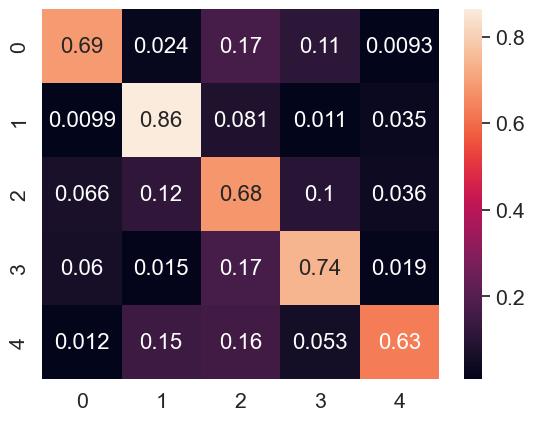

In [12]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, 1)
y_test = np.argmax(y_test, 1)
c = confusion_matrix(y_test, y_pred)
normed_c = c / np.sum(c, axis=1, keepdims=True)
df_cm = pd.DataFrame(normed_c, range(5), range(5))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

In [13]:
from tensorflow.keras import layers
model = tf.keras.Sequential([
    layers.Conv2D(250, kernel_size=5, padding="same", activation="relu", input_shape=(8, 8, 12)),
    layers.Conv2D(150, kernel_size=5, padding="same", activation="relu"),
    layers.Flatten(),
    layers.Dense(32, activation="relu"),
    layers.Dense(5, activation="softmax"),
])
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["categorical_accuracy"])
history2 = model.fit(X_train, y_train, epochs=100, batch_size=2048, shuffle=True, validation_data = (X_validate, y_validate),callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_categorical_accuracy", patience = 5, restore_best_weights = True)])

Epoch 1/100
172/172 [==============================] - 178s 1s/step - loss: 1.0403 - categorical_accuracy: 0.5441 - val_loss: 0.9181 - val_categorical_accuracy: 0.5932
Epoch 2/100
172/172 [==============================] - 176s 1s/step - loss: 0.8655 - categorical_accuracy: 0.6284 - val_loss: 0.8253 - val_categorical_accuracy: 0.6484
Epoch 3/100
172/172 [==============================] - 175s 1s/step - loss: 0.7830 - categorical_accuracy: 0.6706 - val_loss: 0.7766 - val_categorical_accuracy: 0.6779
Epoch 4/100
172/172 [==============================] - 176s 1s/step - loss: 0.7114 - categorical_accuracy: 0.7077 - val_loss: 0.7453 - val_categorical_accuracy: 0.6917
Epoch 5/100
172/172 [==============================] - 176s 1s/step - loss: 0.6526 - categorical_accuracy: 0.7365 - val_loss: 0.7289 - val_categorical_accuracy: 0.7037
Epoch 6/100
172/172 [==============================] - 176s 1s/step - loss: 0.6007 - categorical_accuracy: 0.7613 - val_loss: 0.7192 - val_categorical_accuracy:

1371/1371 [==============================] - 9s 6ms/step


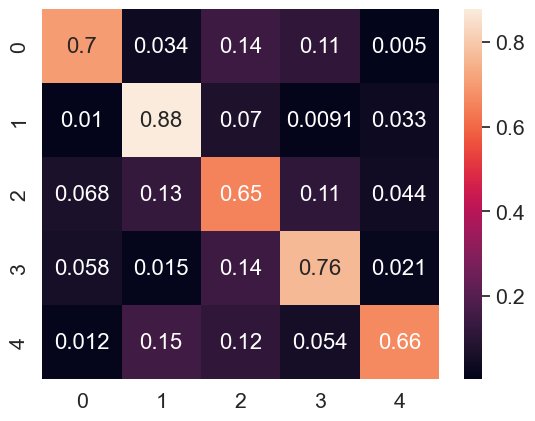

In [14]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, 1)
# y_test = np.argmax(y_test, 1)
c = confusion_matrix(y_test, y_pred)
normed_c = c / np.sum(c, axis=1, keepdims=True)
df_cm = pd.DataFrame(normed_c, range(5), range(5))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

In [15]:
input1 = tf.keras.layers.Input(shape=(8,8,12))
conv1 = tf.keras.layers.Conv2D(kernel_size=(8,8), padding="same", activation="relu", filters=64, input_shape=(8,8,12))(input1)
bn1 = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-05)(conv1)
conv2 = tf.keras.layers.Conv2D(kernel_size=(8,8), padding="same", activation="relu", filters=64, input_shape=(8,8,12))(bn1)
bn2 = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-05)(conv2)
flatten1 = tf.keras.layers.Flatten()(bn2)
Denselayer1 = tf.keras.layers.Dense(1024, activation='relu')(flatten1)
Denselayer2 = tf.keras.layers.Dense(512, activation='relu')(Denselayer1)
Denselayer3 = tf.keras.layers.Dense(256, activation='relu')(Denselayer2)
Denselayer4 = tf.keras.layers.Dense(256, activation='relu')(Denselayer3)
Output = tf.keras.layers.Dense(5, activation='softmax')(Denselayer4)

optimizer = tf.keras.optimizers.Adam()
model = tf.keras.models.Model(inputs=input1, outputs=Output)
model.compile(optimizer=optimizer, 
                   loss=tf.keras.losses.CategoricalCrossentropy(),
                   metrics=tf.keras.metrics.CategoricalAccuracy())
history3 = model.fit(X_train, y_train, epochs=100, batch_size=2048, validation_data = (X_validate, y_validate),callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_categorical_accuracy", patience = 5, restore_best_weights = True)])

Epoch 1/100
172/172 [==============================] - 112s 646ms/step - loss: 0.9002 - categorical_accuracy: 0.6160 - val_loss: 1.8229 - val_categorical_accuracy: 0.1952
Epoch 2/100
172/172 [==============================] - 111s 646ms/step - loss: 0.6736 - categorical_accuracy: 0.7252 - val_loss: 1.9132 - val_categorical_accuracy: 0.2904
Epoch 3/100
172/172 [==============================] - 111s 647ms/step - loss: 0.5241 - categorical_accuracy: 0.7924 - val_loss: 1.6916 - val_categorical_accuracy: 0.2915
Epoch 4/100
172/172 [==============================] - 112s 649ms/step - loss: 0.3937 - categorical_accuracy: 0.8476 - val_loss: 0.7851 - val_categorical_accuracy: 0.6880
Epoch 5/100
172/172 [==============================] - 111s 647ms/step - loss: 0.2939 - categorical_accuracy: 0.8871 - val_loss: 0.7208 - val_categorical_accuracy: 0.7559
Epoch 6/100
172/172 [==============================] - 112s 649ms/step - loss: 0.2288 - categorical_accuracy: 0.9130 - val_loss: 0.8215 - val_cat

1371/1371 [==============================] - 9s 7ms/step


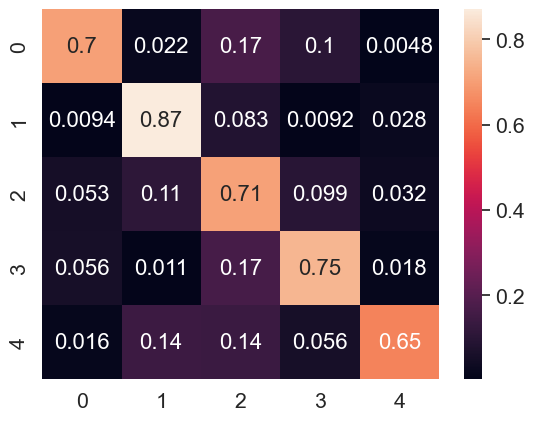

In [16]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, 1)
# y_test = np.argmax(y_test, 1)
c = confusion_matrix(y_test, y_pred)
normed_c = c / np.sum(c, axis=1, keepdims=True)
df_cm = pd.DataFrame(normed_c, range(5), range(5))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

As you can see the last model performs the best but not by a large margin (this was seen on just overall accuracy of the test set). Taking into account the training time and the time it takes to output predictions I decided to go with the 3rd model, although there is a strong argument for the first model. It takes the least time to train and about 1/3 the time to output its predictions with only a drop in .02 in accuracy. However since accuracy was what I wanted to be the highest I decided to let slip the need, only for these experiments, for a much faster prediction. This will be further discussed in the deployment part of this project.

## Diagnosis

This is where I will discuss why I chose the optimizers and learning rate that I chose in order to complete the model selection process. I chose the adam optimizer as I had tested the SGD optimizer and it performed at a worse rate, in addition the Adam optimizer is considered normal for categorization problem. The SGD optimizer still worked, although I never tried it with a lower learning rate, it just didn't reach the same peak val_categorical_accuracy that the Adam optimizer did so I went with the ladder.

I chose to use the learning rate of .001 as when it got lower it wouldn't reach the same val_categorical_accuracy and putting it any higher would make the val_categorical_accuracy stay the same. The only reason I would have used a lower learning rate is to lower the val_loss as it would slowly get higher as the model overfit to the training data, even if the accuracy rose. This is why I chose the stopping condition of all the models to be a dip in categorical accuracy. When I tried using the loss as the stopping condition the accuracy would fall with no general increase in the quality of the confusion matrix, meaning that it still missed the same categories to the same categories.

Distribution of different Categories for training set:
[[     0 142662]
 [     1 120674]
 [     2  87524]]
1371/1371 [==============================] - 9s 6ms/step


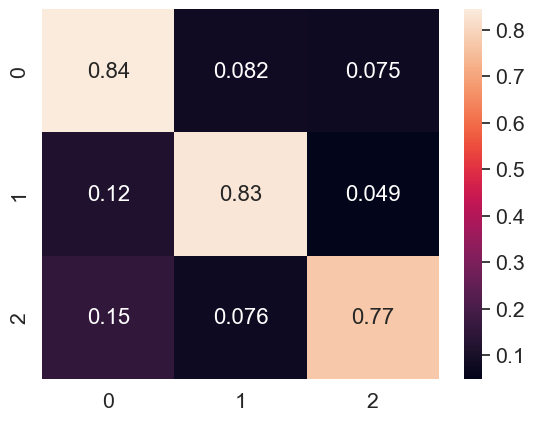

Distribution of different Categories for training set:
[[     0  42906]
 [     1 111443]
 [     2 101384]
 [     3  69128]
 [     4  25999]]
1371/1371 [==============================] - 12s 9ms/step


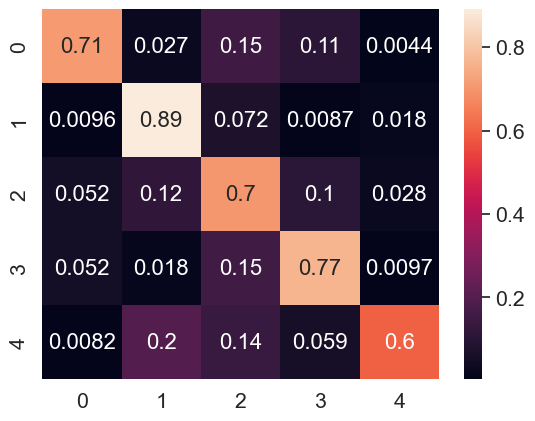

Distribution of different Categories for training set:
[[     0  28400]
 [     1   2221]
 [     2 111230]
 [     3 120778]
 [     4  69348]
 [     5   1775]
 [     6  17108]]
1371/1371 [==============================] - 15s 11ms/step


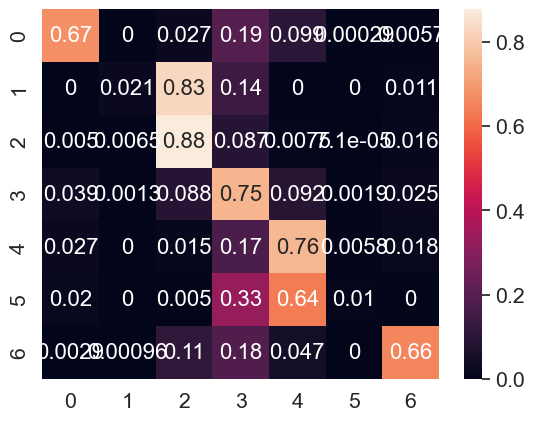

Distribution of different Categories for training set:
[[     0   9317]
 [     1   1665]
 [     2  58550]
 [     3 112252]
 [     4  20115]
 [     5  70099]
 [     6  70345]
 [     7   1124]
 [     8   7393]]
1371/1371 [==============================] - 19s 13ms/step


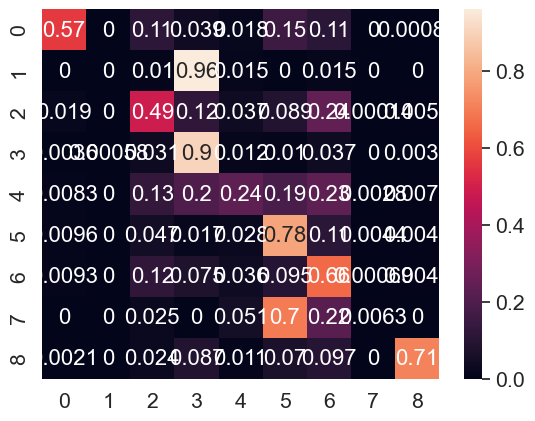

Distribution of different Categories for training set:
[[     0    112]
 [     1     81]
 [     2   1911]
 [     3  65626]
 [     4 112395]
 [     5  16460]
 [     6  70141]
 [     7  82658]
 [     8   1285]
 [     9    130]
 [    10     61]]
1371/1371 [==============================] - 20s 15ms/step


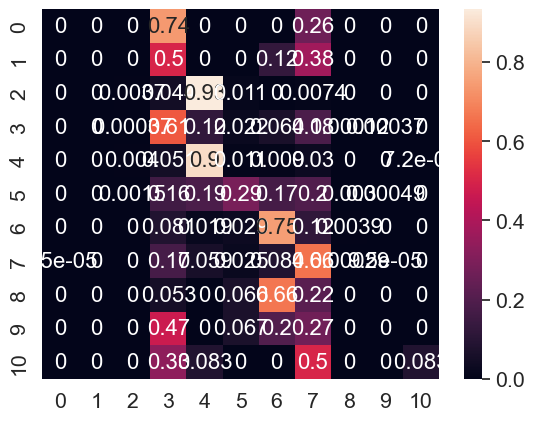

In [2]:
acc_plot = np.zeros(5)
from accvscat import accvscat
for i in range(1,6):
    acc_plot[i-1] = accvscat(i)

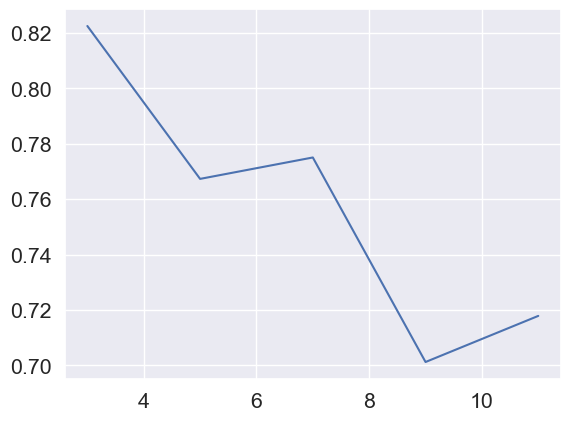

In [3]:
plt.plot([3,5,7,9,11], acc_plot)
plt.xlabel("Categories")
plt.ylabel("Validation Accuracy")
plt.title("Number of Categories vs Accuracy")

## Analysis Part 1


At first glance the results may seem odd but I think the confusion matrices and distribution actually show exactly why the accuracy would jump up at 7 and at 11. This is because, even at 9 categories, the model at 11 categories mistakes the last 3 categories as completely different categories. This is because in total they are around 4,000 data points for 6 categories, making it so the model performs better by missclassifying these points to categories that have a higher number of data points. This can also be seen in the 7 categories but to a smaller degree. The first and fifth category have about 4,000 data points between the two and this leads to higher accuracy by the model if it just missclassifies these points. This is why I chose to use 5 categories to test my models as 7 spread the data too thin and 3 was easier on all the models making it an extremely close call.

The next analysis will be showing which way of preprocesssing the data was better. Flipping the evaluation, swapping the case of the FEN string, and reversing it if it is blacks turn to move. Or, simply having blacks pieces be represented by -1 if its white turn to move and having whites pieces be represented by a -1 if its blacks turn to move.

In [1]:
from accvsproc import accvsproc
(first, second) = accvsproc()

Epoch 1/100
172/172 [==============================] - 177s 1s/step - loss: 0.9273 - categorical_accuracy: 0.6064 - val_loss: 1.7430 - val_categorical_accuracy: 0.0750
Epoch 2/100
172/172 [==============================] - 174s 1s/step - loss: 0.6876 - categorical_accuracy: 0.7180 - val_loss: 1.6311 - val_categorical_accuracy: 0.2439
Epoch 3/100
172/172 [==============================] - 173s 1s/step - loss: 0.5413 - categorical_accuracy: 0.7854 - val_loss: 1.2932 - val_categorical_accuracy: 0.3666
Epoch 4/100
172/172 [==============================] - 169s 987ms/step - loss: 0.4126 - categorical_accuracy: 0.8398 - val_loss: 0.7050 - val_categorical_accuracy: 0.7240
Epoch 5/100
172/172 [==============================] - 171s 993ms/step - loss: 0.3111 - categorical_accuracy: 0.8802 - val_loss: 0.7172 - val_categorical_accuracy: 0.7552
Epoch 6/100
172/172 [==============================] - 199s 1s/step - loss: 0.2402 - categorical_accuracy: 0.9090 - val_loss: 0.7927 - val_categorical_acc

Text(0.5, 1.0, 'Accuracy values vs. Different Preprocessing Methods')

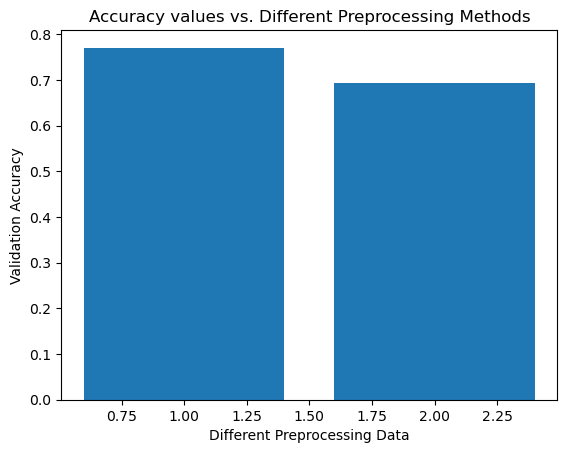

In [6]:
plt.bar((1,2), (first,second))
plt.xlabel("Different Preprocessing Data")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy values vs. Different Preprocessing Methods")

## Analysis Part 2

I think these results more or less speak for themselves as one just performs better than the other. It is why I chose to use the first preprocessing in my first analysis instead of the second. It shows the models perform with better accuracy when they only have to learn from "white's perspective" so to speak. The flipping, reversing the case, and flipping the evaluation all make it so the model has to do a lot less work where as simply reversing the sign only does the model one favor. 

## Deployment

While this project may not see any commercial use it will be put to personal use in my next project of building a chess AI. This is why the speed of predictions along with accuracy was a necessary componenet. This will be the way I evaluate whether one boardstate is better than another in move generation. It will be a key compoenent in the chess AI because its ouput will decide which move/move tree to go down when using minimax algorithms. Here I will briefly describe the chess AI I plan on building using pythons chess library. I will use the chess library to generate the possible moves, then use a minimax algorith (most likely with alpha-beta pruning) which will use this projects evaluation process to determine which move is "best". This will mean that I will have to change this problem back into a regression problem. But as was shown in the categorical problems I know what hurdles I need to overcome to get a good model that can truly learn from the patterns of a chess game. For the regression problem I will most likely test it on the tactical evaluations (the ones I didn't use in training), to determine if the model has truly learned the nuances of the chess game beyond what a heuristic evaluation can. 

How would the minimax algorithm use the evaluation function to find the best move? It will call the evaluation function, after determining all moves upto a depth limit or upto when the game has ended choosing the maximizing score for when it is the players turn and choosing the minimizing score for when it is the opponents turn. The evaluation model will be called on all the leaf nodes of the tree created and based on whose move it is the minimizing score or the maximizing score will be passed up the tree to its parent node. In order to beat heuristic evaluations our model will have had to have learned some of the patterns of chess and realize the importance of not just pieces but of board control, king safety, sacrfices, etc.

Why does the model have to be fast at predictions and why would this cause me to most likely want to use the first model as the evaluation model for my chess AI. This is because it allows us to go to further depths without taking a very long time to compute all the leaf nodes evaluations. Alpha Zero and Stockfish, the two best chess AI in the world, both are able to go to very high depths and calculate there evaluations very fast and under time constraints. This is what I will strive to do so the loss of .02 accuracy can be looked over by its overall speed in calculating at far greater depths than the other two. Obviously the first model will suffer from the same hurdles the third model did in training so the necessary steps to take towards creating a truly good regression evaluation model will stay the same.

## Conclusion
This project has outlined the creation, analysis, and possible deployment of a chess evaluation neural network. It was truly my pleasure to make this and figure out the necessary hurdles I will need to clear when I eventually treat this as a regression problem. I may, in the future, continue to find a better way to preprocess the data for the regression problem but it will have to out perform my current strategy.

## References
1. Joshua Doknjas, "How the AI Revolution Impacted Chess (1/2)",https://en.chessbase.com/post/how-the-ai-revolution-impacted-chess-1-2
2. Joshua Doknjas, "How the AI Revolution Impacted Chess (2/2)",https://en.chessbase.com/post/how-the-ai-revolution-impacted-chess-2-2
3. the_real_greko, "Representations of Chess: FEN, PGN, and Bitboards", https://www.chess.com/blog/the_real_greco/representations-of-chess-fen-pgn-and-bitboards
4. Matthia Sabatelli,Francesco Bidoia, Valeriu Bogdan Codreanu, Marco Wiering, "Learning to Evaluate Chess Positions with Deep Neural Networks andLimited Lookahead", https://www.researchgate.net/publication/322539902_Learning_to_Evaluate_Chess_Positions_with_Deep_Neural_Networks_and_Limited_Lookahead
5. Stockfish, "Introducing NNUE Evaluation", https://stockfishchess.org/blog/2020/introducing-nnue-evaluation/
6. Barak Oshri, Nishith Khandwala, "Predicting Moves in Chess using Convolutional Neural Networks", http://cs231n.stanford.edu/reports/2015/pdfs/ConvChess.pdf
7. Eric Bernhardsson, "Deep Learning for ... chess", https://erikbern.com/2014/11/29/deep-learning-for-chess.html
8. Christopher Clark, Amos Storkey, "Teaching Deep Convolutional Neural Networks to Play Go", https://arxiv.org/abs/1412.3409
9. "Mastering the game of Go without human knowledge", https://www.nature.com/articles/nature24270.epdf?author_access_token=VJXbVjaSHxFoctQQ4p2k4tRgN0jAjWel9jnR3ZoTv0PVW4gB86EEpGqTRDtpIz-2rmo8-KG06gqVobU5NSCFeHILHcVFUeMsbvwS-lxjqQGg98faovwjxeTUgZAUMnRQ (about 20 authors)
10. Shiva Maharaj, Nick Polson, Alex Turk, "Chess AI: Competing Paradigms for Machine Intelligence", https://www.mdpi.com/1099-4300/24/4/550